In [3]:
import json
import pandas as pd
import colorsys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from os import listdir
from PIL import Image as PImage

from utils.image_utils import *
from utils.data_utils import GaussianClustering




In [4]:
def rgb_to_saturation(c):
    r, g, b = c[0] / 255.0, c[1] / 255.0, c[2] / 255.0
    hsv = colorsys.rgb_to_hsv(r,g,b)
    return hsv[1]

In [5]:


def get_main_colors_clusters(imgPath): 
    # get image and convert pixels into a dataframe
    pimg = PImage.open(imgPath).convert("RGB")
    pxs = get_pixels(pimg)
    pxs_df = pd.DataFrame(pxs, columns = ['R', 'G', 'B'])
    print("got pixels")
    

    # create clustering model
    model = GaussianClustering(n_clusters = 5) #get 8 colors first
    print("fitting")
    predicted = model.fit_predict(pxs_df[['R', 'G', 'B']])
    print("trained model")

    # post process clustering result
    ccounts = predicted['clusters'].value_counts()
    colors = []
    for clusterNum in ccounts.index:
        r,g,b = model.cluster_centers_[clusterNum]
        colors.append([round(r), round(g), round(b)])
    print('getting color info')

    sorted_colors = sorted(colors, key=rgb_to_saturation, reverse=True)

    return sorted_colors, pxs_df, colors, predicted


In [6]:
sorted_colors, pxs_df, colors, predicted = get_main_colors_clusters('./tmp/past.png')

got pixels
fitting
trained model
getting color info


1066336 clusters
3    441702
0    195226
2    191792
1    156252
4     81364
Name: count, dtype: int64
5 [[29, 29, 13], [12, 16, 11], [76, 93, 76], [120, 102, 57], [107, 74, 29]]
[2 2 2 ... 3 3 3]


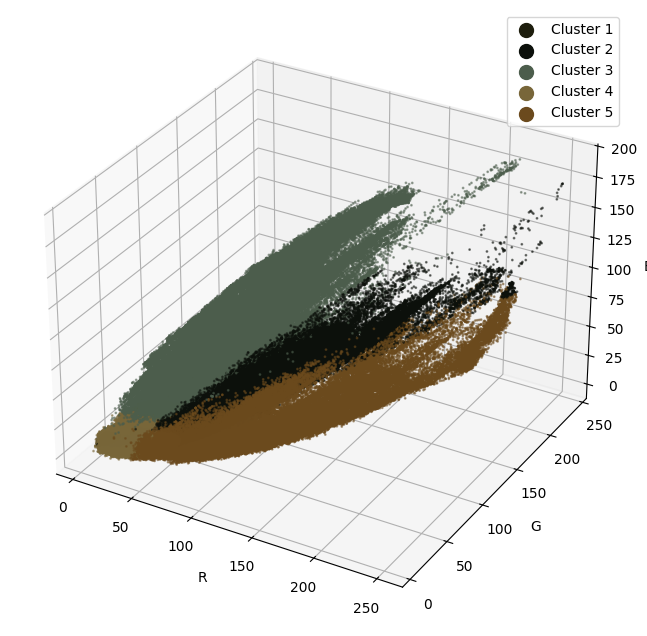

In [7]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

clusters = predicted['clusters'].values
print(len(clusters), predicted['clusters'].value_counts())
print(len(colors), colors)

# Normalize cluster center colors for plotting
colors_normalized = [[x / 255.0 for x in color] for color in colors]

print(clusters)
# Map predicted cluster labels to their corresponding colors
pixel_colors = [colors_normalized[label] for label in clusters]
pixel_colors_2 = [colors[label] for label in clusters]

# Plot pixels in 3D space using their actual cluster colors
ax.scatter(pxs_df['R'], pxs_df['G'], pxs_df['B'], c=pixel_colors, s=1, alpha=0.5)

# Plot the cluster centers
for idx, color in enumerate(colors_normalized):
    ax.scatter(color[0]*255, color[1]*255, color[2]*255, c=[color], marker='o', s=100, label=f"Cluster {idx+1}")

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.legend()
plt.show()

1066336
[[29, 29, 13], [12, 16, 11], [76, 93, 76], [120, 102, 57], [107, 74, 29]]


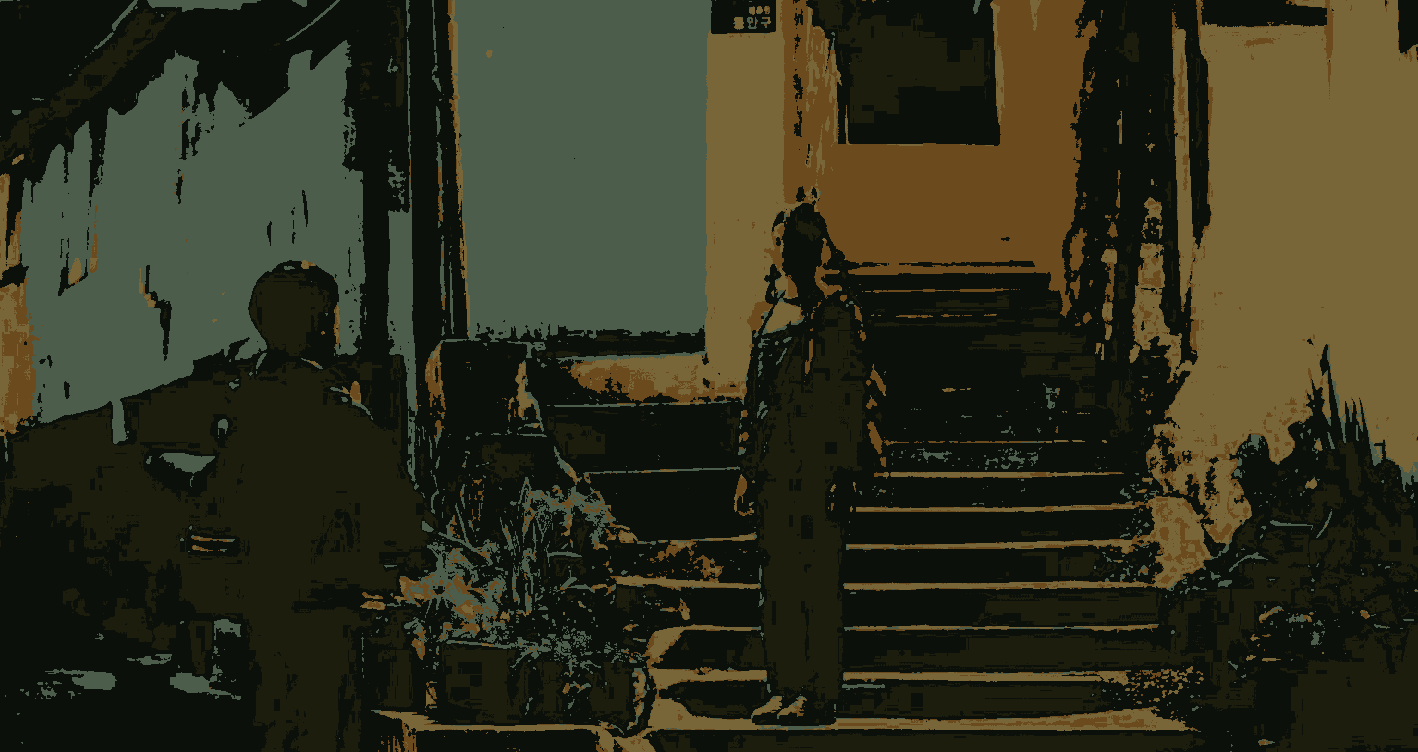

In [25]:

pimg = PImage.open('./tmp/past.png').convert("RGB")
print(len(clusters))
print(colors)
colors2 = [colors[0],[120, 102, 57], [76, 93, 76], colors[1], [107, 74, 29]]
pixel_colors_2 = [colors2[label] for label in clusters]

display(make_image(pixel_colors_2, width=pimg.width, height=pimg.height)) 


In [26]:
def color_distance(c1, c2):
        d = 0
        for i in range(len(c1)):
            d += (c1[i]-c2[i])**2
        d = d**.5
        return d

def get_main_colors(imgPath,  color_similarity_threshold = 80):
    pimg =  PImage.open(imgPath).convert("RGB")
    pxs = get_pixels(pimg)

    main_colors = []

    def color_unique(c):
        for existing_color in main_colors:
            dist = color_distance(existing_color, c) 
            # print(dist)
            if dist < color_similarity_threshold: 
                return False, existing_color
        
        return True, c

    for color in pxs:
        unique, color = color_unique(color)

        if unique:
            main_colors.append(color)

    main_colors = [list(c) for c in main_colors]
    sorted_colors = sorted(main_colors, key=rgb_to_saturation, reverse=True)
    return sorted_colors[:8]

def map_pixels_to_main_colors(pxs, main_colors):
    mapped_pixels = []
    for color in pxs:
        # Find the closest main color
        min_dist = float('inf')
        closest_color = None
        for main_color in main_colors:
            dist = color_distance(color, main_color)
            if dist < min_dist:
                min_dist = dist
                closest_color = main_color
        mapped_pixels.append(tuple(closest_color))
    return mapped_pixels

def plot_pixels_3d(imgPath, main_colors):
    pimg = PImage.open(imgPath).convert("RGB")
    pxs = get_pixels(pimg)

    # Initialize the 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a list to store the corresponding RGB values for each pixel
    colors_for_plot = []

    for color in pxs:
        # Find the closest main color
        min_dist = float('inf')
        closest_color = None
        for main_color in main_colors:
            dist = color_distance(color, main_color)
            if dist < min_dist:
                min_dist = dist
                closest_color = main_color
        
        # Add the closest color to the list for plotting
        colors_for_plot.append(closest_color)

    # Plot the pixels in 3D space (RGB values as coordinates)
    colors_for_plot = [[float(x)/255 for x in c] for c in colors_for_plot]
    pxs_df = pd.DataFrame(pxs, columns=['R', 'G', 'B'])
    ax.scatter(pxs_df['R'], pxs_df['G'], pxs_df['B'], c=colors_for_plot, s=1, alpha=0.5)

    # Label axes
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')


    mpxs = map_pixels_to_main_colors(pxs, main_colors)
    display(make_image(mpxs, width=pimg.width, height=pimg.height))
 


    # Display the plot
    plt.show()

In [27]:
main_colors = get_main_colors('./tmp/past.png')
print(main_colors)

[[100, 46, 14], [163, 130, 53], [237, 182, 78], [23, 48, 43], [244, 225, 158], [85, 112, 84], [141, 169, 135]]


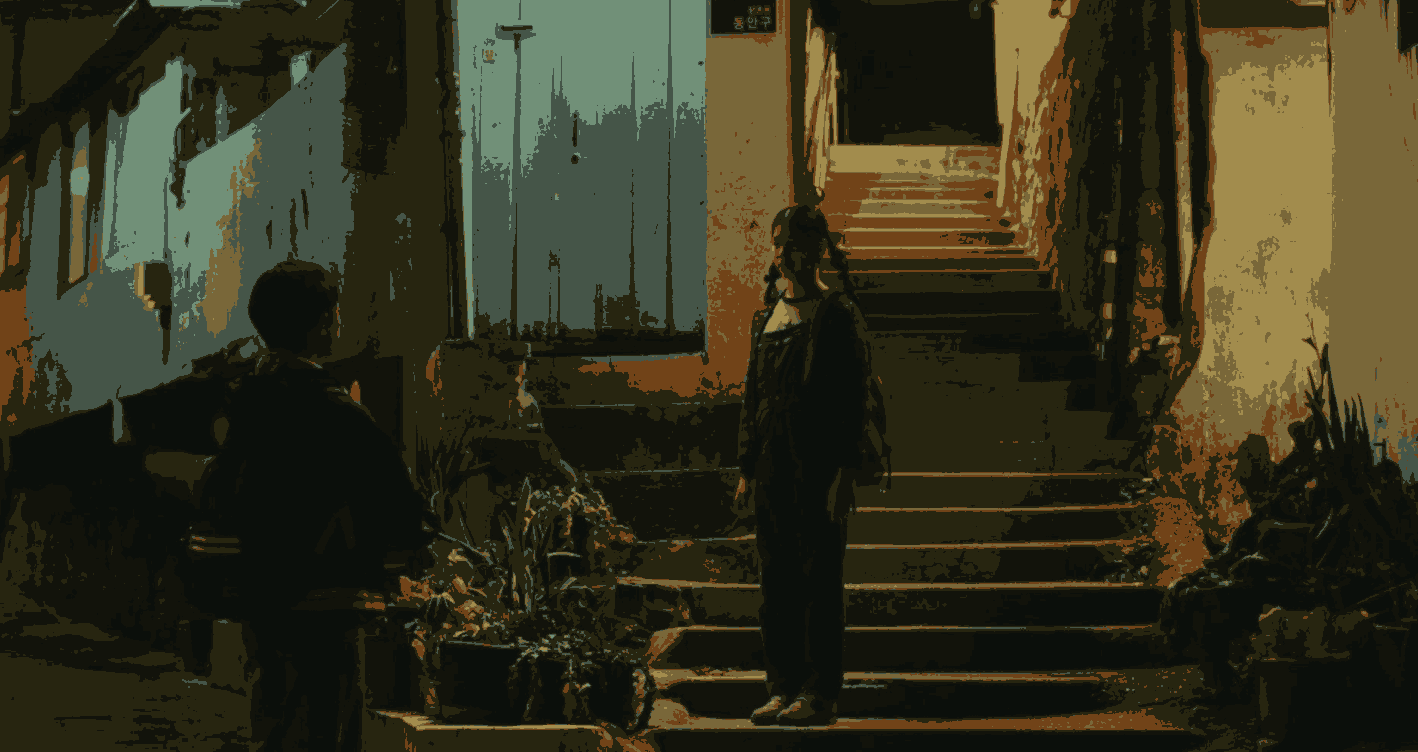

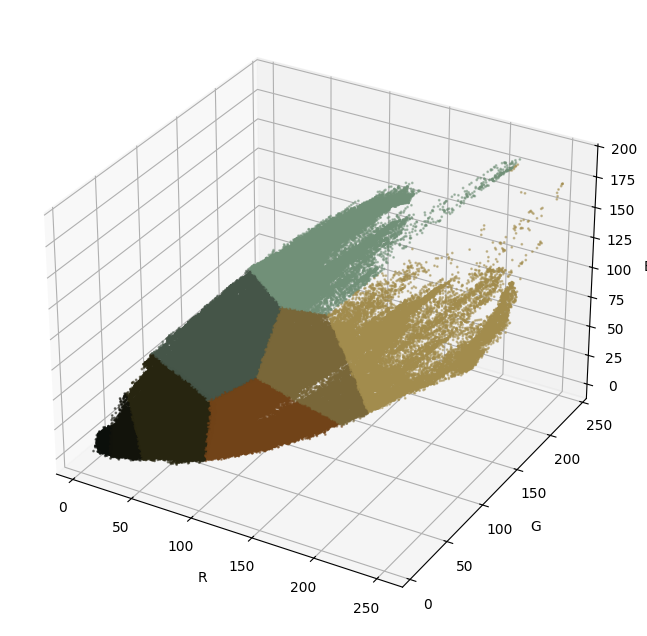

In [51]:
plot_pixels_3d('./tmp/past.png', sorted_colors)